In [ ]:
# Install the necessary libraries
!pip install transformers torch
!pip install emot
!pip install spacy
!python -m spacy download en_core_web_lg

2023-12-24 19:13:52.659672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 19:13:52.659740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 19:13:52.661178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 19:13:53.972129: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
# Sentiment Analysis of Naira Redesign 2023 Policy and Nigerian Presidential Elections
import nltk
import spacy
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
import numpy as np
import pandas as pd
from imblearn.under_sampling import ClusterCentroids
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, recall_score, precision_score
import warnings

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Set the limits for Pandas Dataframe display to avoid potential system freeze
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 15)
pd.set_option('display.max_colwidth', 40)

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Loading the dataset

In [ ]:
# Loading the scrapped twitter dataset into a Panda DataFrame
naira_data = pd.read_excel("naira_tweets.xlsx")
election_data = pd.read_excel("election_tweets.xlsx")

In [ ]:
# Merging the dataset
raw_merged_df = pd.concat([naira_data, election_data], ignore_index=True)

In [ ]:
#merged dataset info
raw_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294006 entries, 0 to 294005
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tweet_id        294006 non-null  int64  
 1   User_Location   223006 non-null  object 
 2   Tweet_Content   293968 non-null  object 
 3   Tweet_DateTime  294006 non-null  object 
 4   impression      293057 non-null  float64
 5   like_count      294006 non-null  int64  
 6   reply_count     294006 non-null  int64  
 7   retweet_count   294006 non-null  int64  
 8   quote_count     294006 non-null  int64  
 9   tweet_url       294006 non-null  object 
 10  KEYWORD         292253 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 24.7+ MB


In [ ]:
# Statistical information of the merged dataset
raw_merged_df.describe()

,tweet_id,impression,like_count,reply_count,retweet_count,quote_count
count,2.940060e+05,2.930570e+05,294006.000000,294006.000000,294006.000000,294006.000000
mean,1.560027e+18,1.017082e+03,12.805303,1.396057,3.705724,0.239652
std,2.766167e+17,1.348604e+04,194.959565,22.600696,56.446986,4.801453
min,7.270930e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.611106e+18,2.100000e+01,0.000000,0.000000,0.000000,0.000000
50%,1.617656e+18,6.000000e+01,0.000000,0.000000,0.000000,0.000000
75%,1.623100e+18,2.170000e+02,2.000000,1.000000,0.000000,0.000000
max,1.629270e+18,3.480966e+06,58961.000000,5125.000000,9485.000000,964.000000


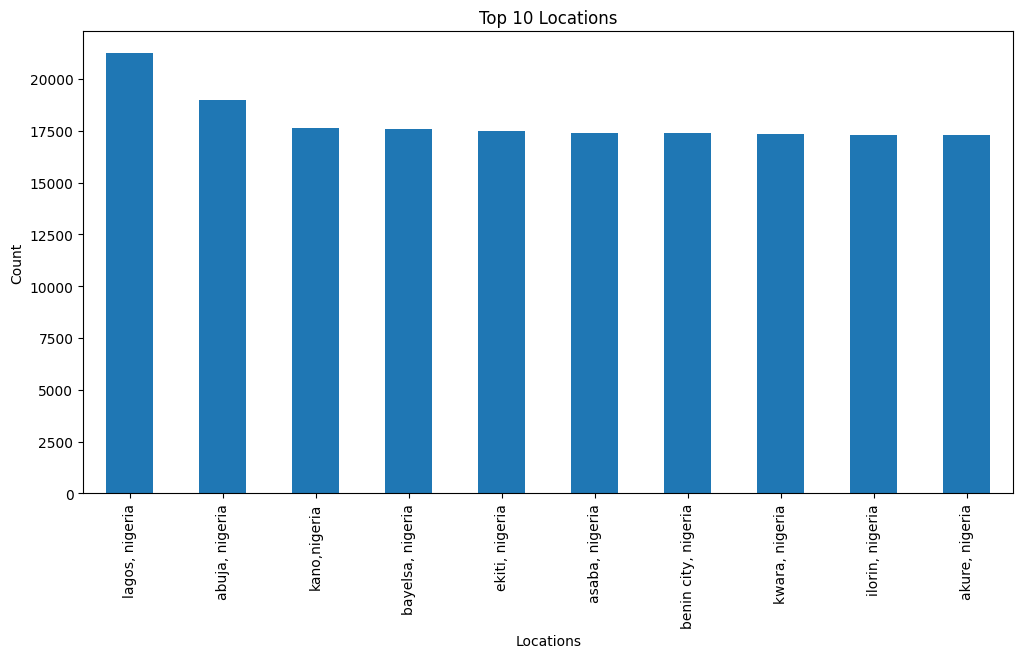

In [ ]:
# Graph of the top 10 user's location
raw_merged_df['User_Location'] = raw_merged_df['User_Location'].str.lower().dropna()
location_counts = raw_merged_df["User_Location"].value_counts()[:10]
plt.figure(figsize=(12, 6))
location_counts.plot(kind='bar', title='Top 10 Locations')
plt.xlabel('Locations')
plt.ylabel('Count')
plt.show()

In [ ]:
# Keywords related to the Naira policy in the election tweets dataset

policy_keywords = ["cash", "bank", "atm", "pos", "cbn", "cbn governor", "cashswap",
                   "deadline", "extension", "naira crisis", "buy", "new note", "old note",
                   "new naira", "old naira", "deposit", "withdraw", "currency",
                   "naira", "money", "emefiele", "redesign", "design", "policy", "policies"]

In [ ]:
election_data

,tweet_id,User_Location,Tweet_Content,Tweet_DateTime,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORD
0,1606413344822490112,"Lagos, Nigeria",@jidesanwoolu E no go better for APC...,2022-12-23 22:16:01+00:00,356.0,3,0,0,0,https://twitter.com/UKASON5/status/1...,APC
1,1606413005939510016,"Benin city, Nigeria",@06trigga @dumdozzy @jarmari01 @Mari...,2022-12-23 22:14:40+00:00,16.0,0,0,0,0,https://twitter.com/anembaben/status...,APC
2,1606412654368659968,"Enugu, Nigeria",This is why APC must never return. T...,2022-12-23 22:13:17+00:00,4669.0,18,1,15,1,https://twitter.com/asemota/status/1...,APC
3,1606412262587219968,"Akure, Nigeria",Two people God will punish this peri...,2022-12-23 22:11:43+00:00,307.0,4,0,2,0,https://twitter.com/DeraOnuh/status/...,APC
4,1606410662388930048,"Ilorin, Nigeria",@Better_Kaduna @elrufai @KCTA_KD @Ha...,2022-12-23 22:05:22+00:00,239.0,4,0,0,0,https://twitter.com/ChuksRaph2020/st...,APC
...,...,...,...,...,...,...,...,...,...,...,...
215207,1605706813537760000,"Bauchi, Nigeria",@Canbini @JoyUkaha @GazetteNGR @Pete...,2022-12-21 23:28:31+00:00,26.0,0,0,0,0,https://twitter.com/BishopEze7/statu...,APC
215208,1606055194198000128,"Bauchi, Nigeria","BREAKING: ARISE TV, ThisDay Publishe...",2022-12-22 22:32:52+00:00,25.0,0,0,0,0,https://twitter.com/TheNigerianBar/s...,APC
215209,1606413949125139968,"Bauchi, Nigeria",@kingkhone4real @GoziconC Not by IPO...,2022-12-23 22:18:25+00:00,34.0,0,1,0,0,https://twitter.com/ezicandid/status...,APC
215210,704730131508633600,"Bauchi, Nigeria",Rt. Hon. \n@IsaAshiruKudan\n has rec...,2022-12-25 19:59:57+00:00,131.0,5,0,4,0,https://twitter.com/Samsongalaaxy/st...,NNPP


In [ ]:
# Filter tweets containing both policy and election keywords
policy_tweets = election_data[election_data['Tweet_Content'].apply(lambda x: any(keyword in str(x) for keyword in policy_keywords))]


In [ ]:
policy_tweets

,tweet_id,User_Location,Tweet_Content,Tweet_DateTime,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORD
1,1606413005939510016,"Benin city, Nigeria",@06trigga @dumdozzy @jarmari01 @Mari...,2022-12-23 22:14:40+00:00,16.0,0,0,0,0,https://twitter.com/anembaben/status...,APC
2,1606412654368659968,"Enugu, Nigeria",This is why APC must never return. T...,2022-12-23 22:13:17+00:00,4669.0,18,1,15,1,https://twitter.com/asemota/status/1...,APC
21,1606778061768339968,"Benin city, Nigeria",@potentialprof11 @Sadiyahamza41 Who ...,2022-12-24 22:25:17+00:00,104.0,2,0,0,0,https://twitter.com/EmekaNkwuaku/sta...,APC
22,1606777057639529984,"Kano,Nigeria",@SaharaReporters @officialEFCC @Offi...,2022-12-24 22:21:17+00:00,647.0,1,1,0,0,https://twitter.com/Joy19962458/stat...,APC
25,1607144334368839936,"Ekiti, Nigeria",@Ch12206535Chris @Makavelli275 ðŸ˜‚ð...,2022-12-25 22:40:43+00:00,109.0,1,0,0,0,https://twitter.com/Gruka001/status/...,APC
...,...,...,...,...,...,...,...,...,...,...,...
215185,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS
215195,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC
215205,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS
215206,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,INEC


In [ ]:
# Merging the polcy tweet filtered data to Naria dataset
data = pd.concat([naira_data, policy_tweets], ignore_index=True)


In [ ]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        98327 non-null  int64  
 1   User_Location   27327 non-null  object 
 2   Tweet_Content   98302 non-null  object 
 3   Tweet_DateTime  98327 non-null  object 
 4   impression      98122 non-null  float64
 5   like_count      98327 non-null  int64  
 6   reply_count     98327 non-null  int64  
 7   retweet_count   98327 non-null  int64  
 8   quote_count     98327 non-null  int64  
 9   tweet_url       98327 non-null  object 
 10  KEYWORD         98193 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 8.3+ MB


,tweet_id,impression,like_count,reply_count,retweet_count,quote_count
count,9.832700e+04,9.812200e+04,98327.000000,98327.000000,98327.000000,98327.000000
mean,1.517623e+18,1.295586e+03,12.005726,1.453995,3.681807,0.277950
std,3.609259e+17,1.484597e+04,157.928475,16.250996,50.130311,4.826697
min,7.270930e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.612930e+18,2.200000e+01,0.000000,0.000000,0.000000,0.000000
50%,1.619629e+18,6.500000e+01,0.000000,0.000000,0.000000,0.000000
75%,1.624172e+18,2.460000e+02,2.000000,1.000000,0.000000,0.000000
max,1.629270e+18,2.072581e+06,21653.000000,1507.000000,5312.000000,519.000000


# Exploratory Data Analysis

In [ ]:
# A quick overlook of the dataset
data.head(10)

,tweet_id,User_Location,Tweet_Content,Tweet_DateTime,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORD
0,1609699208541659904,NaN,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN
1,1609698822233479936,NaN,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN
2,1609697932235729920,NaN,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN
3,1609689801212689920,NaN,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN
4,1609684243650579968,NaN,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
5,1609683706394050048,NaN,@bingils @damilare_solu @woye1 Still...,2023-01-01 22:51:16+00:00,11.0,0,0,0,0,https://twitter.com/omoonoshi/status...,CBN
6,1609677830903950080,NaN,The CBN governor is a card-carrying ...,2023-01-01 22:27:55+00:00,46.0,0,0,0,0,https://twitter.com/joseph_enan/stat...,CBN
7,1609676650534370048,NaN,Medical Tourism Straining Nigeriaâ€™...,2023-01-01 22:23:14+00:00,12.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN
8,1609675297150089984,NaN,SAD NEWS: Heavily Armed Assassins to...,2023-01-01 22:17:51+00:00,595.0,1,0,0,0,https://twitter.com/chefkalee/status...,CBN
9,1609674811470469888,NaN,New year new season! The Vikings wil...,2023-01-01 22:15:56+00:00,6217.0,48,1,10,0,https://twitter.com/BC_Baseball/stat...,CBN


In [ ]:
# Get number of rows and columns
data.shape

(98327, 11)

In [ ]:
# Summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,98327.0,1.517623e+18,3.609259e+17,727093.0,1.612930e+18,1.619629e+18,1.624172e+18,1.629270e+18
impression,98122.0,1.295586e+03,1.484597e+04,0.0,2.200000e+01,6.500000e+01,2.460000e+02,2.072581e+06
like_count,98327.0,1.200573e+01,1.579285e+02,0.0,0.000000e+00,0.000000e+00,2.000000e+00,2.165300e+04
reply_count,98327.0,1.453995e+00,1.625100e+01,0.0,0.000000e+00,0.000000e+00,1.000000e+00,1.507000e+03
retweet_count,98327.0,3.681807e+00,5.013031e+01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.312000e+03
quote_count,98327.0,2.779501e-01,4.826697e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.190000e+02


#### Data Cleaning & Preprocessing

In [ ]:
# Check for duplicate values
data.duplicated(subset='tweet_id').sum()


10311

In [ ]:
# Drop duplicate values
data = data.drop_duplicates(subset=['tweet_id'])


In [ ]:
# Check for "NaN" values
data.isna().any()

tweet_id          False
User_Location      True
Tweet_Content      True
Tweet_DateTime    False
impression         True
like_count        False
reply_count       False
retweet_count     False
quote_count       False
tweet_url         False
KEYWORD            True
dtype: bool

In [ ]:
# Counting the missing values in each column
data.isna().sum()

tweet_id              0
User_Location     66435
Tweet_Content        24
Tweet_DateTime        0
impression          184
like_count            0
reply_count           0
retweet_count         0
quote_count           0
tweet_url             0
KEYWORD              82
dtype: int64

In [ ]:
# Remove rows with NaN values in 'Text content'
data = data.dropna(subset=['Tweet_Content'])


In [ ]:
# Drop duplicate values
data = data.drop_duplicates(subset=['tweet_id'])


In [ ]:
# Drop duplicate Text content values
data = data.drop_duplicates(subset=['Tweet_Content'])


In [ ]:
# Replace "NaN" values in the User_Location column with "No Location"
data['User_Location'] = data['User_Location'].fillna('No location')

In [ ]:
# Replace "NaN" values in the impression column with 0
data['impression'] = data['impression'].fillna(0)

In [ ]:
# Replace "NaN" values in the KEYWORDS column with "PVC"
data['KEYWORD'] = data['KEYWORD'].fillna("PVC")

In [ ]:
# Check to see if "NaN" values are available
data.isna().any()


tweet_id          False
User_Location     False
Tweet_Content     False
Tweet_DateTime    False
impression        False
like_count        False
reply_count       False
retweet_count     False
quote_count       False
tweet_url         False
KEYWORD           False
dtype: bool

In [ ]:
# A function to expand contractions in text
def expand_contractions(text):
    expanded_text = []
    for word in text:
        if re.search("n't", word):
            expanded_text.append(word.split("n't")[0])
            expanded_text.append("not")
        else:
            expanded_text.append(word)
    return expanded_text

In [ ]:
# Define a set of stopwords
STOPWORDS = set(stopwords.words('english'))

# Remove 'not' and 'no' from the set
STOPWORDS.discard("not")
STOPWORDS.discard("no")

# Initialize the TweetTokenizer for handling tweets
tweet_tokenizer = TweetTokenizer()

# A function to preprocess text
def preprocess_text(text):
    # Convert tweets to lowercase
    text = text.lower()

    # Remove Twitter usernames
    text = re.sub(r"@[\w]*", "", text)

    # Remove URLs
    text = re.sub(r"https?://\S*|www\.\S*", "", text)

    # Remove non-alphabets, and symbols while preserving emojis
    text = re.sub(r"[^a-zA-Z' \U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FAC0-\U0001FAFF\U0001FB00-\U0001FBFF\U0001F004-\U0001F0CF\U0001F18E-\U0001F1FF\U0001F6C6-\U0001F6FF\U0001F950-\U0001F95F\U0001F96C-\U0001F97F\U0001F992-\U0001F9B2\U0001F9D0-\U0001F9FF\U0001F3FB-\U0001F3FF]*", "", text, flags=re.MULTILINE)

    # Remove single characters
    text = re.sub(r"(^| ).( |$)", " ", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text using the TweetTokenizer
    tokens = tweet_tokenizer.tokenize(text)

    # Remove stopwords
    words = [word for word in tokens if word not in STOPWORDS]

    # Expand contractions
    words = expand_contractions(words)

    # Lemmatize words
    word_lemmatizer = WordNetLemmatizer()
    words = [word_lemmatizer.lemmatize(word) for word in words]

    # Join words back into a text
    cleaned_text = " ".join(words)

    return cleaned_text


In [ ]:
# Clean and preprocess the 'Text' column to processed_text column
#
data["Processed_text"] = data["Tweet_Content"].apply(preprocess_text)


In [ ]:
# Decribe the data after cleaning and preporocessing
data.describe()


,tweet_id,impression,like_count,reply_count,retweet_count,quote_count
count,8.663300e+04,8.663300e+04,86633.000000,86633.000000,86633.000000,86633.000000
mean,1.556789e+18,1.345904e+03,12.266619,1.488186,3.707663,0.281913
std,2.872762e+17,1.554303e+04,164.115888,16.471425,50.658732,4.913254
min,7.270930e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.614011e+18,2.200000e+01,0.000000,0.000000,0.000000,0.000000
50%,1.619823e+18,6.700000e+01,0.000000,0.000000,0.000000,0.000000
75%,1.624467e+18,2.520000e+02,2.000000,1.000000,0.000000,0.000000
max,1.629270e+18,2.072581e+06,21653.000000,1507.000000,5312.000000,519.000000


In [ ]:
# Decribe the data after cleaning and preporocessing
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86633 entries, 0 to 98326
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        86633 non-null  int64  
 1   User_Location   86633 non-null  object 
 2   Tweet_Content   86633 non-null  object 
 3   Tweet_DateTime  86633 non-null  object 
 4   impression      86633 non-null  float64
 5   like_count      86633 non-null  int64  
 6   reply_count     86633 non-null  int64  
 7   retweet_count   86633 non-null  int64  
 8   quote_count     86633 non-null  int64  
 9   tweet_url       86633 non-null  object 
 10  KEYWORD         86633 non-null  object 
 11  Processed_text  86633 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 8.6+ MB


##DATA LABELLING

#### Data Labelling

Using existing sentiment analysis libraries or tools to automate the labeling process for the dataset due to its size

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# A function for calculating sentiment polarity
def calculate_sentiment(text):
    # Initialize VADER
    analyzer = SentimentIntensityAnalyzer()

    # Analyze sentiment for the entire tweet
    return analyzer.polarity_scores(text)


In [ ]:
# Apply sentiment analysis to the 'Text' column
data['Sentiment_polarity'] = data['Processed_text'].apply(calculate_sentiment)


In [ ]:
# Get sentiment category from polarity scores
def get_sentiment(score):
    score = score['compound']
    if score > 0:
        return 1
    elif score < 0:
        return -1
    else:
        return 0

In [ ]:
# Get sentiments from the sentiment_polarity column
data["Sentiment"] = data["Sentiment_polarity"].apply(get_sentiment)

In [ ]:
data

,tweet_id,User_Location,Tweet_Content,Tweet_DateTime,impression,like_count,reply_count,retweet_count,quote_count,tweet_url,KEYWORD,Processed_text,Sentiment_polarity,Sentiment
0,1609699208541659904,No location,DISTURBING NEWS: Heavily Armed Assas...,2023-01-01 23:52:52+00:00,498.0,1,0,0,0,https://twitter.com/ZamfaraR/status/...,CBN,disturbing news heavily armed assass...,"{'neg': 0.216, 'neu': 0.784, 'pos': ...",-1
1,1609698822233479936,No location,@mrojo88 @ademolababaD @dmightyangel...,2023-01-01 23:51:20+00:00,32.0,0,0,0,0,https://twitter.com/baTeeatus/status...,CBN,melancholic doltish narrative bullio...,"{'neg': 0.051, 'neu': 0.87, 'pos': 0...",1
2,1609697932235729920,No location,We offer affordable HPLC for testing...,2023-01-01 23:47:48+00:00,103.0,1,0,1,0,https://twitter.com/cannabistest1/st...,CBN,offer affordable hplc testing cannab...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...",0
3,1609689801212689920,No location,Still On CBN And The Cashless Econom...,2023-01-01 23:15:29+00:00,12.0,0,0,0,0,https://twitter.com/OpinionNigeria/s...,CBN,still cbn cashless economy humdrum g...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...",0
4,1609684243650579968,No location,CBN Retains Benchmark Interest Rate ...,2023-01-01 22:53:24+00:00,11.0,0,0,0,0,https://twitter.com/PilotAfrican/sta...,CBN,cbn retains benchmark interest rate ...,"{'neg': 0.0, 'neu': 0.786, 'pos': 0....",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98321,1605707410793969920,"Yobe, Nigeria",@AdisaMichael9 @O_basslet Afonu ni e...,2022-12-21 23:30:53+00:00,53.0,1,1,0,0,https://twitter.com/mytymtwitz/statu...,APC,afonu ni ein peak covid bite osun st...,"{'neg': 0.045, 'neu': 0.874, 'pos': ...",1
98322,785090725,"Yobe, Nigeria",Many Nigerians i suppose are not wel...,2023-01-02 13:57:13+00:00,377.0,1,0,2,0,https://twitter.com/muky_zanna/statu...,BVAS,many nigerian suppose not well acqua...,"{'neg': 0.064, 'neu': 0.851, 'pos': ...",1
98323,1605706969557250048,"Zamfara, Nigeria",@abikedabiri @officialABAT @Official...,2022-12-21 23:29:08+00:00,10.0,0,0,0,0,https://twitter.com/Badejo2007/statu...,APC,great,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0,...",1
98324,2931066720,"Bauchi, Nigeria",I am grateful to God for grace of an...,2023-02-17 23:51:19+00:00,645.0,11,2,2,0,https://twitter.com/olatunjiolumid3/...,BVAS,grateful god grace another new year ...,"{'neg': 0.0, 'neu': 0.608, 'pos': 0....",1


#### Visualization/Data Analysis



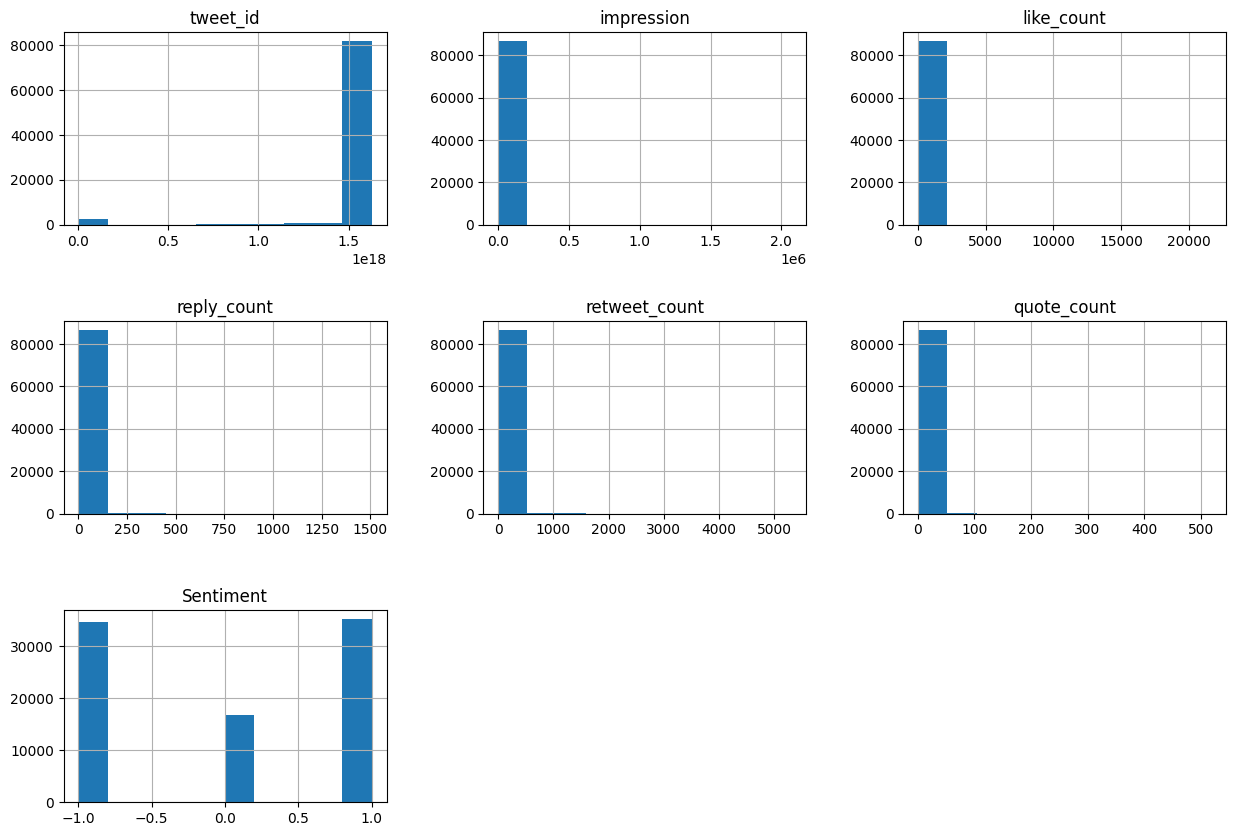

In [ ]:
# Plot the histogram
data.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [ ]:
data['Sentiment_polarity']

0        {'neg': 0.216, 'neu': 0.784, 'pos': ...
1        {'neg': 0.051, 'neu': 0.87, 'pos': 0...
2        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...
3        {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...
4        {'neg': 0.0, 'neu': 0.786, 'pos': 0....
                          ...                   
98321    {'neg': 0.045, 'neu': 0.874, 'pos': ...
98322    {'neg': 0.064, 'neu': 0.851, 'pos': ...
98323    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0,...
98324    {'neg': 0.0, 'neu': 0.608, 'pos': 0....
98326    {'neg': 0.284, 'neu': 0.601, 'pos': ...
Name: Sentiment_polarity, Length: 86633, dtype: object

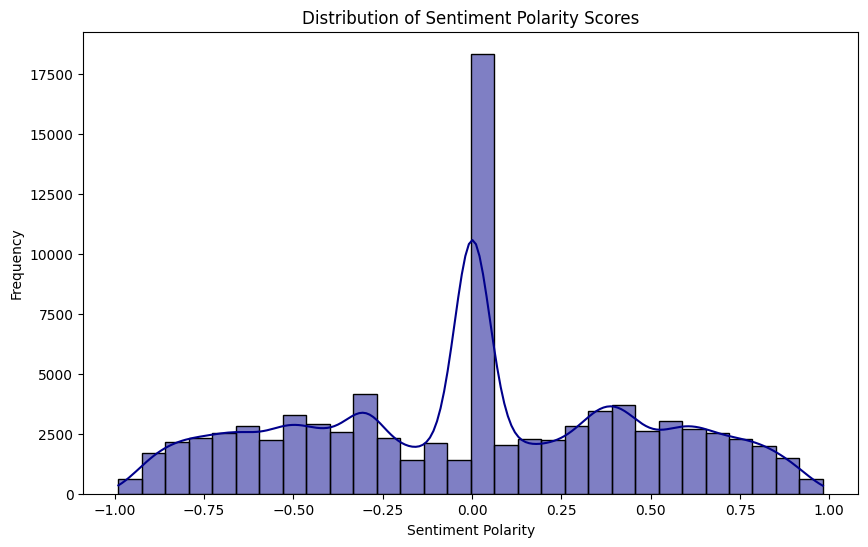

In [ ]:
# Extract 'compound' sentiment scores
compound_scores = data['Sentiment_polarity'].apply(lambda x: x['compound'])

# Plot the distribution of 'compound' sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(compound_scores, bins=30, kde=True, color='darkblue')
plt.title('Distribution of Sentiment Polarity Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Analyze the overall sentiment landscape
positive_sentiment = len(data[data['Sentiment'] == 1])
neutral_sentiment = len(data[data['Sentiment'] == 0])
negative_sentiment = len(data[data['Sentiment'] == -1])

sentiment_summary = pd.DataFrame({'Sentiment': ['Positive', 'Neutral', 'Negative'],
                                  'Count': [positive_sentiment, neutral_sentiment, negative_sentiment]})
sentiment_summary


,Sentiment,Count
0,Positive,35272
1,Neutral,16761
2,Negative,34600


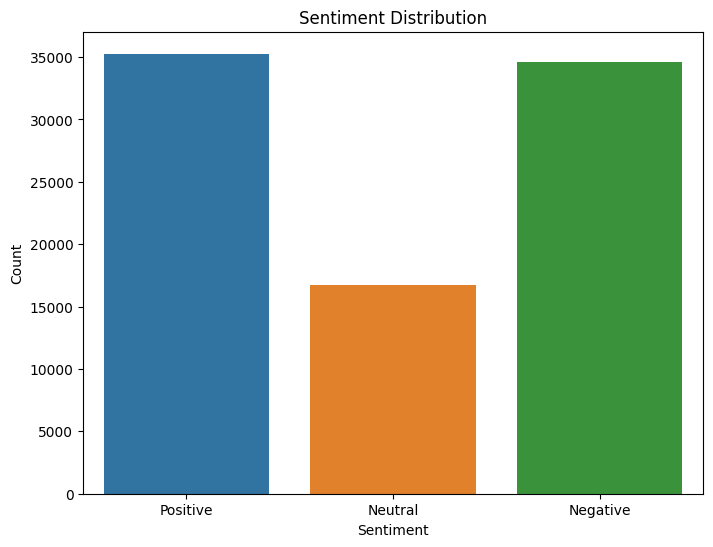

In [ ]:
# Visualize the sentiment summary
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_summary)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


##Top Hashtag during the period

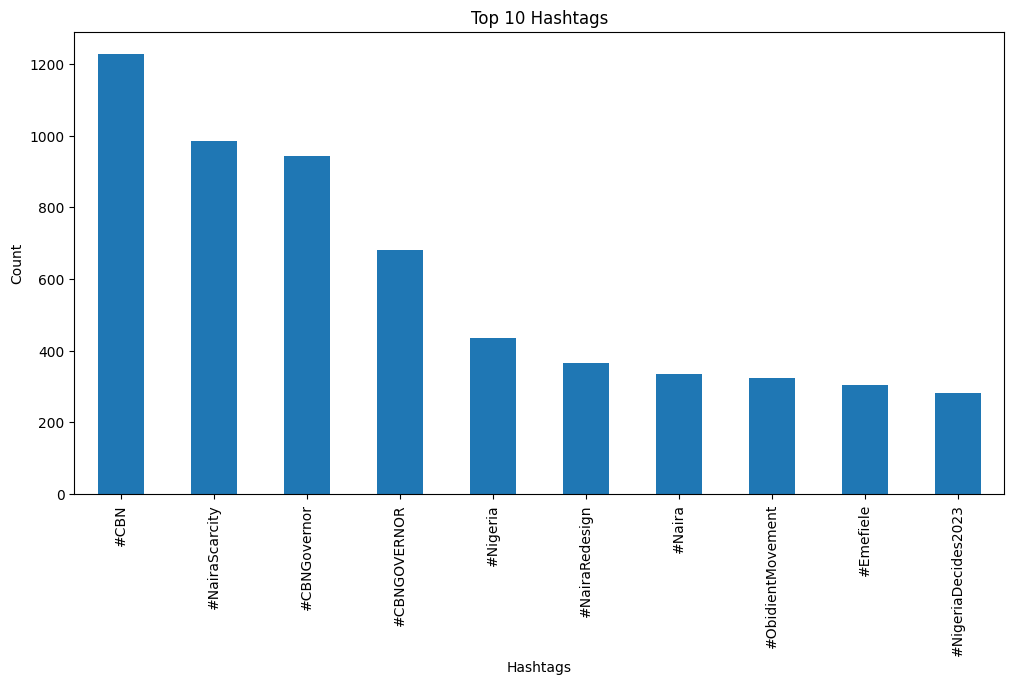

In [ ]:
# Extract hashtags from the 'Text' column
data['hashtags'] = data['Tweet_Content'].apply(lambda x: re.findall(r'#\w+', x))

# Plot hashtags over time
hashtags = [tag for sublist in data['hashtags'] for tag in sublist]
hashtag_counts = pd.Series(hashtags).value_counts()[:10]
plt.figure(figsize=(12, 6))
hashtag_counts.plot(kind='bar', title='Top 10 Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Count')
plt.show()

**Most common words used by Twitter Users to describe the policy during election**

In [ ]:
from nltk import pos_tag

# A function to obtain adjectives from tweets
def get_adjectives(text):
    # Convert string to tokens
    tokens = word_tokenize(text)

    # POS tagging
    adjectives = [word for (word, tag) in pos_tag(tokens) if tag.startswith("JJ")]

    # Join adjectives with spaces
    return " ".join(adjectives)


In [ ]:
data.to_csv('Tweets_Processed.csv',encoding='utf-8-sig', index=False)

In [ ]:
# Apply get_adjectives function to the new 'Processed Tweets' column
data['Users_perception'] = data['Processed_text'].apply(get_adjectives)

# Extract the 'Users_Perception' column to a list
users_perception = data['Users_perception'].tolist()

# Join the list elements into a single string
users_perception = " ".join(users_perception)


In [ ]:
data['Users_perception']

0           new kehinde fatinoye couple domestic
1        melancholic doltish narrative van co...
2                     affordable current thc usd
3                                       cashless
4                     benchmark monetary central
                          ...                   
98321                                ein wealthy
98322    many nigerian new electoral next nig...
98323                                      great
98324           grateful new happy atiku nigeria
98326                                       ipob
Name: Users_perception, Length: 86633, dtype: object

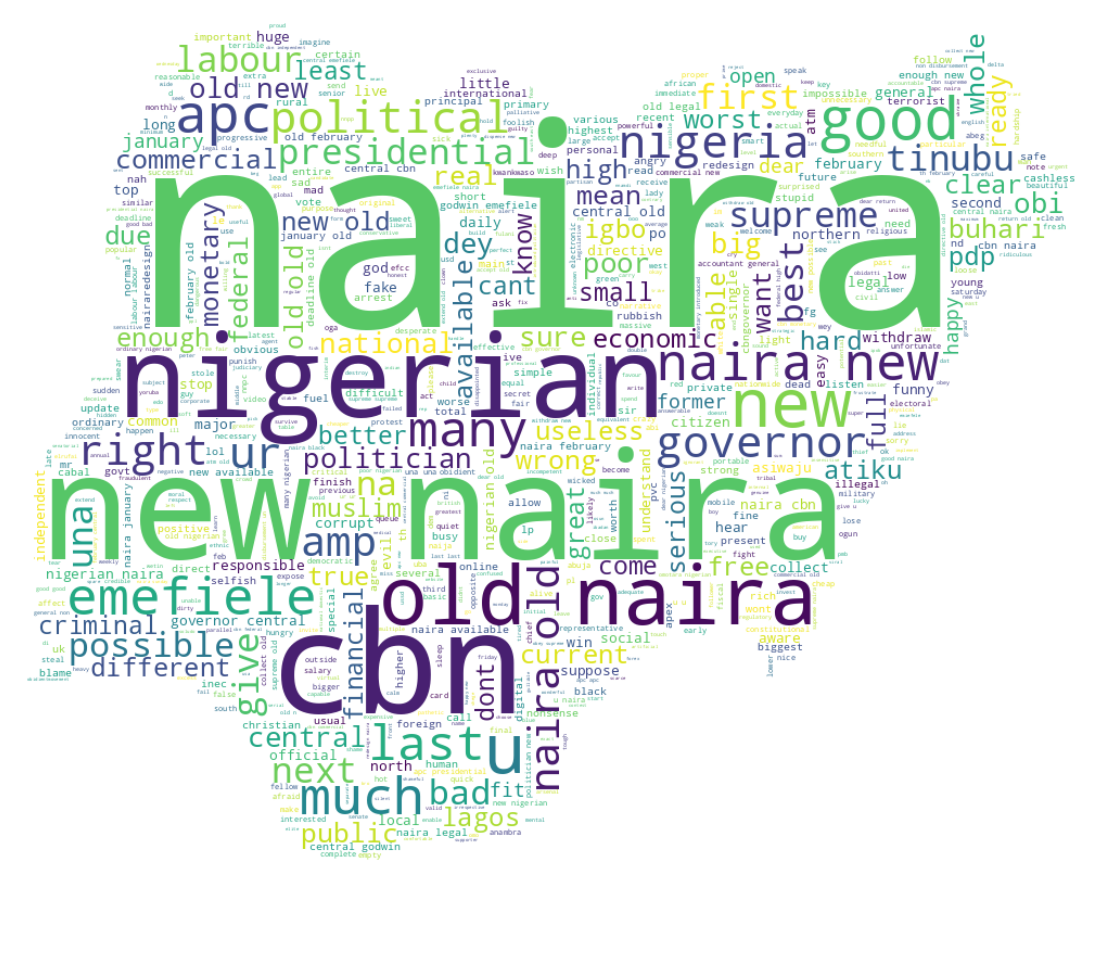

In [ ]:
# Instantiate the Word Cloud object
mask = np.array(Image.open(r'Ngnmap.jpg'))
wc = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])

# generate the word cloud
wc.generate(users_perception)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

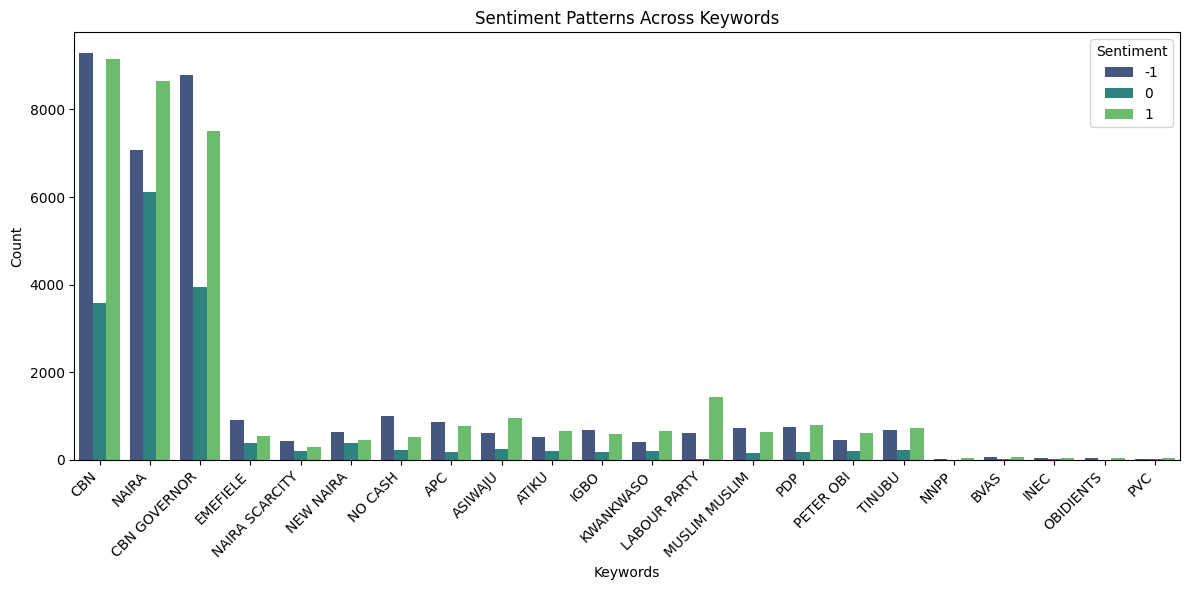

In [ ]:
# Visualize sentiment patterns across different keywords
plt.figure(figsize=(12, 6))
sns.countplot(x='KEYWORD', hue='Sentiment', data=data, palette='viridis')
plt.title('Sentiment Patterns Across Keywords')
plt.xlabel('Keywords')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

##Balancing dataset


In [ ]:
X = data.drop(columns=["Sentiment"])

# Sentiment, the target variable
y = data["Sentiment"]

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Create a RandomUnderSampler instance
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X, y)


In [ ]:
# Check the class distribution after undersampling
print("Class distribution after undersampling:")
print(y_resampled.value_counts())


Class distribution after undersampling:
-1    16761
 0    16761
 1    16761
Name: Sentiment, dtype: int64


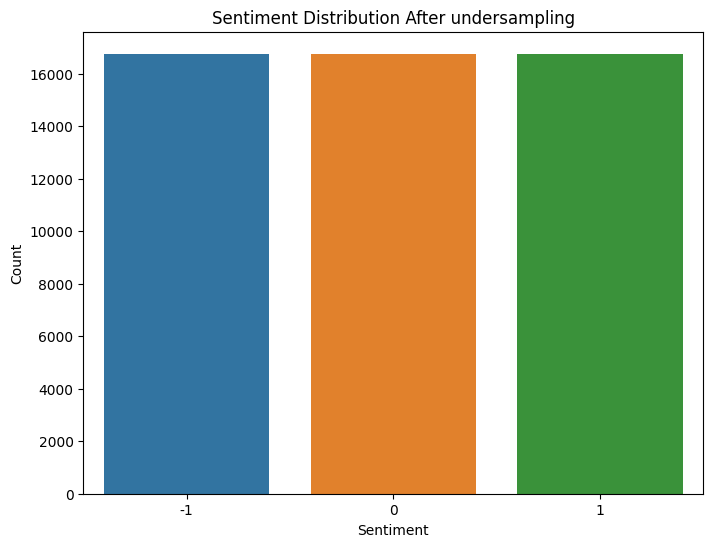

In [ ]:
# Visualize the sentiment summary
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Sentiment Distribution After undersampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

## Sentiment Analysis Model Development

LSTM


In [ ]:
# Data preprocessing
max_words = 10000  # Maximum number of words to keep based on word frequency
max_len = 100  # Maximum length of a sequence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_resampled['Processed_text'])
sequences = tokenizer.texts_to_sequences(X_resampled['Processed_text'])
X_encoded = pad_sequences(sequences, maxlen=max_len)

le = LabelEncoder()
y_transform = le.fit_transform(y_resampled)
y_encoded = to_categorical(y_transform)  # Convert to one-hot encoding

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 50  # Dimension of the embedding layer
hidden_units = 100  # Number of LSTM units

Lstm_model = Sequential()
Lstm_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
Lstm_model.add(LSTM(hidden_units))
Lstm_model.add(Dense(len(le.classes_), activation='softmax'))

Lstm_model .compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
Lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = Lstm_model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Make predictions
y_pred_probabilities = Lstm_model.predict(X_test)


Epoch 1/5
1006/1006 [==============================] - 68s 65ms/step - loss: 0.6090 - accuracy: 0.7348 - val_loss: 0.3816 - val_accuracy: 0.8690
Epoch 2/5
1006/1006 [==============================] - 65s 65ms/step - loss: 0.2982 - accuracy: 0.8977 - val_loss: 0.3419 - val_accuracy: 0.8814
Epoch 3/5
1006/1006 [==============================] - 66s 65ms/step - loss: 0.2263 - accuracy: 0.9243 - val_loss: 0.3311 - val_accuracy: 0.8826
Epoch 4/5
1006/1006 [==============================] - 66s 65ms/step - loss: 0.1607 - accuracy: 0.9446 - val_loss: 0.3240 - val_accuracy: 0.8930
Epoch 5/5
315/315 [==============================] - 6s 19ms/step - loss: 0.3639 - accuracy: 0.8948
Accuracy: 0.8947996497154236
315/315 [==============================] - 7s 19ms/step


In [ ]:
y_pred_probabilities

array([[9.4535512e-01, 1.5961047e-02, 3.8683850e-02],
       [9.9884230e-01, 5.8286433e-04, 5.7485374e-04],
       [1.4527123e-02, 2.3285362e-03, 9.8314428e-01],
       ...,
       [3.3124283e-02, 6.3357344e-03, 9.6053994e-01],
       [2.8031860e-03, 2.4308118e-03, 9.9476594e-01],
       [5.2352373e-02, 1.0298585e-02, 9.3734902e-01]], dtype=float32)

In [ ]:
# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_pred_labels

array([0, 0, 2, ..., 2, 2, 2])

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3381
           1       0.97      0.94      0.95      3368
           2       0.86      0.88      0.87      3308

    accuracy                           0.89     10057
   macro avg       0.90      0.89      0.90     10057
weighted avg       0.90      0.89      0.90     10057

Accuracy: 0.8947996420403699
F1 Score: 0.8951135065855674
Recall Score: 0.894716630983939
Precision Score: 0.8957445050805868


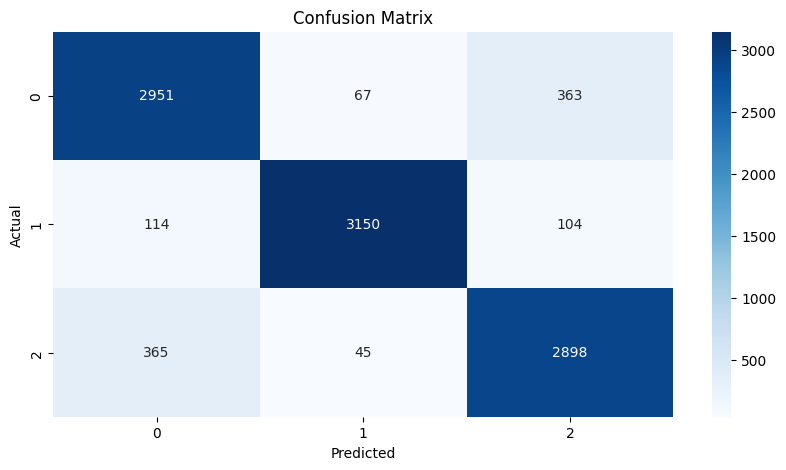

In [ ]:
# Evaluate the LSTM model

y_test_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
classification_rep = classification_report(y_test_labels, y_pred_labels)

print("Classification Report:")
print(classification_rep)
print('Accuracy:', accuracy_score(y_test_labels, y_pred_labels))
print('F1 Score:', f1_score(y_test_labels, y_pred_labels, average='macro'))
print('Recall Score:', recall_score(y_test_labels, y_pred_labels, average='macro'))
print('Precision Score:', precision_score(y_test_labels, y_pred_labels, average='macro'))

# Create subplots
plt.figure(figsize=(10, 5))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plots
plt.show()

###BERT


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

# Split the data
X_resampled, y_encoded = shuffle(X_resampled, y_encoded, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled['Processed_text'], y_encoded, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Tokenize and format the input data

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Create DataLoader
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define training parameters
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

# Training loop
num_epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

for epoch in range(num_epochs):
    bert_model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

# Evaluation
bert_model.eval()
all_preds = []
all_labels = []

for batch in test_loader:
    input_ids, attention_mask, labels = batch
    input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    preds = torch.argmax(logits, dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Convert probabilities to labels
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)
y_pred_labels

In [ ]:
# Decode labels
decoded_preds = le.inverse_transform(all_preds)
decoded_labels = le.inverse_transform(all_labels)

# Evaluate the results
conf_matrix = confusion_matrix(decoded_labels, decoded_preds)
classification_rep = classification_report(decoded_labels, decoded_preds)

print("Classification Report:")
print(classification_rep)
print('Accuracy:', accuracy_score(decoded_labels, decoded_preds))
print('F1 Score:', f1_score(decoded_labels, decoded_preds, average='macro'))
print('Recall Score:', recall_score(decoded_labels, decoded_preds, average='macro'))
print('Precision Score:', precision_score(decoded_labels, decoded_preds, average='macro'))

# Create subplots
plt.figure(figsize=(10, 5))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plots
plt.show()


In [ ]:
# Saving The BERT Model

bert_model.save('bert_model.h5')

#using the model on unlable dataset




In [ ]:
# Assuming naira_data is the DataFrame obtained from the sentiment analysis

# Copy the original DataFrame for each subset
unlab_Naira_CBN = naira_data.copy()
unlab_Naira_Scarcity = naira_data.copy()
unlab_Naira_Design = naira_data.copy()

# Define keywords for each subset
keywords_CBN = ["bank", "atm", "pos", "cbn", "cbn governor",
                "deadline", "extension", "currency",
                "naira", "emefiele", "policy", "policies"]

keywords_Scarcity = ["cash",  "atm", "pos", "cashswap",
                    "deadline", "naira crisis", "buy", "new note", "old note",
                    "old naira", "deposit", "withdraw",
                    "money"]

keywords_Design = ["cash",  "cashswap","new note", "old note",
                    "new naira", "old naira",  "currency",
                    "naira", "money", "redesign", "design"]

# Filter each subset based on keywords
unlab_Naira_CBN = unlab_Naira_CBN[unlab_Naira_CBN['Tweet_Content'].apply(lambda x: any(keyword in str(x) for keyword in keywords_CBN))]
unlab_Naira_Scarcity = unlab_Naira_Scarcity[unlab_Naira_Scarcity['Tweet_Content'].apply(lambda x: any(keyword in str(x) for keyword in keywords_Scarcity))]
unlab_Naira_Design = unlab_Naira_Design[unlab_Naira_Design['Tweet_Content'].apply(lambda x: any(keyword in str(x) for keyword in keywords_Design))]

# Save each subset to a separate CSV file
unlab_Naira_CBN.to_csv('/content/unlab_Naira_CBN.csv', encoding='utf-8-sig', index=False)
unlab_Naira_Scarcity.to_csv('/content/unlab_Naira_Scarcity.csv', encoding='utf-8-sig', index=False)
unlab_Naira_Design.to_csv('/content/unlab_Naira_Design.csv', encoding='utf-8-sig', index=False)


In [ ]:
#### Model implementation

import pandas as pd
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import re

# Load the trained BERT model
loaded_model = load_model('/content/bert_model.h5')

# Load your new dataset (replace 'naira1_tweets.csv' with your file name)
new_data = pd.read_csv('/content/unlab_Naira_Scarcity.csv', encoding='ISO-8859-1')

# Check for NaN values in the 'Tweet_Content' column
new_data['Tweet_Content'].fillna('', inplace=True)

# Drop duplicate values based on 'tweet_id' and 'Tweet_Content'
# Drop duplicate values based on 'tweet_id' and 'Tweet_Content' and reset the index
# Drop duplicate values based on 'tweet_id' and 'Tweet_Content' and reset the index
new_data = new_data.drop_duplicates(subset=['Tweet_Content'], keep='first', inplace=False)




# A function to expand contractions in text
def expand_contractions(text):
    expanded_text = []
    for word in text:
        if re.search("n't", word):
            expanded_text.append(word.split("n't")[0])
            expanded_text.append("not")
        else:
            expanded_text.append(word)
    return expanded_text

# Define a set of stopwords
STOPWORDS = set(stopwords.words('english'))

# Remove 'not' and 'no' from the set
STOPWORDS.discard("not")
STOPWORDS.discard("no")

# Initialize the TweetTokenizer for handling tweets
tweet_tokenizer = TweetTokenizer()

# A function to preprocess text
def preprocess_text(text):
    # Convert tweets to lowercase
    text = text.lower()

    # Remove Twitter usernames
    text = re.sub(r"@[\w]*", "", text)

    # Remove URLs
    text = re.sub(r"https?://\S*|www\.\S*", "", text)

    # Remove non-alphabets, and symbols while preserving emojis
    text = re.sub(r"[^a-zA-Z' \U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FAC0-\U0001FAFF\U0001FB00-\U0001FBFF\U0001F004-\U0001F0CF\U0001F18E-\U0001F1FF\U0001F6C6-\U0001F6FF\U0001F950-\U0001F95F\U0001F96C-\U0001F97F\U0001F992-\U0001F9B2\U0001F9D0-\U0001F9FF\U0001F3FB-\U0001F3FF]*", "", text, flags=re.MULTILINE)

    # Remove single characters
    text = re.sub(r"(^| ).( |$)", " ", text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text using the TweetTokenizer
    tokens = tweet_tokenizer.tokenize(text)

    # Remove stopwords
    words = [word for word in tokens if word not in STOPWORDS]

    # Expand contractions
    words = expand_contractions(words)

    # Lemmatize words
    word_lemmatizer = WordNetLemmatizer()
    words = [word_lemmatizer.lemmatize(word) for word in words]

    # Join words back into a text
    cleaned_text = " ".join(words)

    return cleaned_text

# Clean and preprocess the 'Tweet_Content' column to 'Processed_text' column
new_data["Processed_text"] = new_data["Tweet_Content"].apply(preprocess_text)

# Text preprocessing parameters
max_words = 10000
max_len = 100

# Tokenize and pad the 'Processed_text' column
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_data['Processed_text'])
sequences = tokenizer.texts_to_sequences(new_data['Processed_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Make predictions
predictions = loaded_model.predict(padded_sequences)

# Convert probabilities to sentiment labels
sentiment_labels = [prediction.argmax() for prediction in predictions]

# Map labels to sentiments
sentiment_mapping = {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
new_data['Sentiment'] = [sentiment_mapping[label] for label in sentiment_labels]

# Print or save the results
print(new_data[['Tweet_Content', 'Processed_text', 'Sentiment']])
# Alternatively, save the DataFrame to a new CSV file
# new_data.to_csv('/content/new_data_with_sentiments.csv', encoding='utf-8-sig', index=False)
